In [ ]:
# EWMA time based FTS QUEUE time prediction


In [ ]:
#matplotlib stuff
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 12})

# other imports
import datetime
from elasticsearch import Elasticsearch, helpers
from elasticsearch.helpers import scan
import datetime as dt
import json
import numpy as np
import pandas as pd
import pickle
import requests
import time
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2



from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#### RSE 2 SITE mapping and data retrieving

In [ ]:
# Get AGIS endpoints (RSEs) and site names
r = requests.get('http://atlas-agis-api.cern.ch/request/site/query/list/ddmendpoints?json')
j = r.json()
#Create RSE to site name dictionary
rse2site = {}
for i in j:
    for ep in i['ddmendpoints']:
        rse2site[ep]=i['name']

In [252]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
DATE = '2017-08-01'  # yyyy-mm-dd
DELTA = 4
# Generate the indexes to scan
dt.datetime.strptime(DATE,'%Y-%m-%d')
index_list = []
for i in range(-1, DELTA+1):
    index_list.append('fts_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                      + dt.timedelta(days=i)).strftime('%Y-%m-%d'))
indexes = ','.join(index_list)
print (index_list)
period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=7)
transfer_query = {
    "size": 0,
    "_source": ["src_rse", "dst_rse", "activity","bytes","submitted_at","started_at","transferred_at"],
    'query':{
        "bool" : {
            "must" : [
                {"term" : { "dst" : "CERN-PROD" }},
                {"term" : { "src" : "BNL-ATLAS" }},
                {"range" : {"transferred_at" : {  "gte": period_start } }},
                {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                ]
        }
    }
                
}
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
data = []
for res in scroll:
    r = res['_source']
    if not count%1000000 : print (count)
    r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    data.append([rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']]+'__'+r['activity'],r['bytes'],r['submitted_at'],r['started_at'],r['transferred_at']])
    count += 1
print('Reading took',time.time() - st,'seconds.')
data = pd.DataFrame(data, columns=['LINK', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED'])
data['Q_TIME'] = data['STARTED'] - data['SUBMITTED']
data['N_RATE'] = data.SIZE/(data['ENDED'] - data['STARTED'])
data['T_TIME'] = data['ENDED'] - data['SUBMITTED']

['fts_2017-07-31', 'fts_2017-08-01', 'fts_2017-08-02', 'fts_2017-08-03', 'fts_2017-08-04', 'fts_2017-08-05']
0
Reading took 8.531784057617188 seconds.


## Make prediction using best window size

In [ ]:
def holt_winters_second_order_ewma( x, span, beta ):
    N = x.size
    alpha = 2.0 / ( 1 + span )
    s = np.zeros(( N, ))
    b = np.zeros(( N, ))
    s[0] = x[0]
    for i in range( 1, N ):
        s[i] = alpha * x[i] + ( 1 - alpha )*( s[i-1] + b[i-1] )
        b[i] = beta * ( s[i] - s[i-1] ) + ( 1 - beta ) * b[i-1]
    return s[-1],b[-1]

In [ ]:
def hwsoewma_forcast(s0, b0, beta, span):
    '''Forcast span values after s0'''
    s = [s0]
    b = [b0]
    for i in range(1,span):
        s.append(s[i-1] + i*b[i-1])
        b.append(beta*(s[i] - s[i-1])+(1-beta)*b[i-1])
    return (s,b)

In [162]:
cut = data.where(data.LINK == 'CERN-PROD__NDGF-T1__User Subscriptions').dropna()
cut = cut.set_index(pd.to_datetime(cut.SUBMITTED, unit='s'))
cut = cut.sort_index()
print ((cut.STARTED.values- cut.SUBMITTED.values).mean()/60)
print ((cut.STARTED.values- cut.SUBMITTED.values).std()/60)

3.89210697978
23.8210025327


In [ ]:
cut2 = data.where(data.LINK == 'CERN-PROD__BNL-ATLAS__Production Input').dropna()
cut2 = cut2.set_index(pd.to_datetime(cut2.SUBMITTED, unit='s'))
cut2 = cut2.sort_index()

In [ ]:
l =cut[cut.SUBMITTED == 1485998357.0]
l.Q_TIME.values, l.Q_TIME.mean()

In [ ]:
x = np.linspace(cut.SUBMITTED.min(),cut.SUBMITTED.max(),(cut.SUBMITTED.max()- cut.SUBMITTED.min()))
len(x)

#### Trying to predict based on second bins
The bin contains the mean of all the transfers that start on the same second

In [ ]:
y = []
for i in x:
    xs = cut[cut.SUBMITTED > i]
    xs = cut[cut.SUBMITTED < i+1]
    if len(xs) > 0:
        y.append(xs.Q_TIME.mean())
    else:
        y.append(0)

In [ ]:
#x = np.linspace(cut.SUBMITTED.values,cut.SUBMITTED.values)
plt.plot(cut.SUBMITTED.values,cut.Q_TIME.values,'.', label='real')
plt.plot(x, y,'.', label='binned')
#plt.yscale('log')
#plt.xscale('log')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

This is how binning by seconds looks like ↑

Then I tried ewma over this data with several parameter combinations. Best oneis a beta very low and a span around 60 seconds. Still the predictions diverge very quickly.

In [ ]:
beta = 0.00001
s,b = holt_winters_second_order_ewma(np.array(y[75000:110000]), 100, beta)


In [ ]:
(ss,bb) = hwsoewma_forcast(s,b,beta,7200)


In [ ]:
plt.plot(cut.SUBMITTED.values[200:],cut.Q_TIME.values[200:],'.')
#plt.plot(cut.SUBMITTED.values[100000:100100],cut.Q_TIME.values[100000:100100],'.')
plt.plot(x[110000:111000], ss[:1000],'.')
#plt.yscale('log')
#plt.xscale('log')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.plot(cut.SUBMITTED.values,cut.Q_TIME.values,'.', label='real')
plt.plot(x,y,'.',alpha=0.7,label='binned by minute')
preds = []
for t in range(1,len(y),60):
    beta = 0.0001
    s,b = holt_winters_second_order_ewma(np.array(y[:t]), 60, beta)
    (ss,bb) = hwsoewma_forcast(s,b,beta,60)
#plt.plot(cut.SUBMITTED.values[100000:100100],cut.Q_TIME.values[100000:100100],'.')
    preds.extend(ss)
    try:
        plt.plot(x[t:t+60], ss[:60],'.', color='k',alpha=0.2)
    except:
        continue
#plt.yscale('log')
#plt.xscale('log')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

### Binning by minute
As the ewma did it on seconds basis diverge very quickly, I tried to bin by minute. 

In [ ]:
x = np.linspace(cut.SUBMITTED.min()/60,cut.SUBMITTED.max()/60,(cut.SUBMITTED.max()/60 -cut.SUBMITTED.min()/60))
y = []
for i in x:
    xs = cut[cut.SUBMITTED/60 > i]
    xs = xs[xs.SUBMITTED/60 < i+60]
    if len(xs) > 0:
        y.append(xs.Q_TIME.mean())
    else:
        y.append(0)

In [ ]:
#x = np.linspace(cut.SUBMITTED.values,cut.SUBMITTED.values)
plt.plot(cut.SUBMITTED.values/60,cut.Q_TIME.values,'.', label='real')
plt.plot(x, y,'.',label='binned by minute')
#plt.yscale('log')
#plt.xscale('log')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.plot(cut.SUBMITTED.values/60,cut.Q_TIME.values,'.', label='real')
plt.plot(x,y,'.',alpha=0.7,label='binned by minute')
preds = []
for t in range(1,len(y),60):
    beta = 0.0001
    s,b = holt_winters_second_order_ewma(np.array(y[:t]), 1, beta)
    (ss,bb) = hwsoewma_forcast(s,b,beta,60)
#plt.plot(cut.SUBMITTED.values[100000:100100],cut.Q_TIME.values[100000:100100],'.')
    preds.extend(ss)
    try:
        plt.plot(x[t:t+60], ss[:60],'.', color='k',alpha=0.2)
    except:
        continue
#plt.yscale('log')
#plt.xscale('log')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

This is the behavior of the EWMA based on those 60 minute window, predicting 60 minutes ahead. 

In [ ]:
pred = []
for tup in cut.itertuples():
    pred.append(preds[int(tup.SUBMITTED/60 - cut.SUBMITTED.min()/60)])
cut['Q_PRED'] = pred
r = r2(cut.Q_TIME,cut.Q_PRED)
print (r)

In [ ]:
plt.plot(cut.SUBMITTED.values,cut.Q_TIME.values,'.', label='real')
plt.plot(cut.SUBMITTED.values,cut.Q_PRED.values,'.', label='predicted')
#plt.yscale('log')
#plt.xscale('log')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

### Binning by minute but removing data I don't know at the window time


2694.82110424
1184.84994006


/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


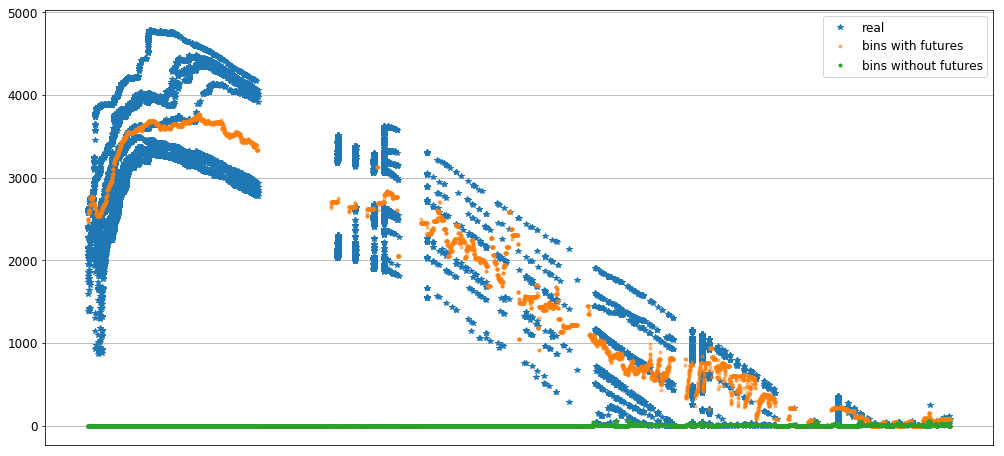

In [259]:
cut = data.where(data.LINK == 'BNL-ATLAS__CERN-PROD__Data Consolidation').dropna()
cut = cut.set_index(pd.to_datetime(cut.SUBMITTED, unit='s'))
cut = cut.sort_index()
print ((cut.STARTED.values- cut.SUBMITTED.values).mean()/60)
print ((cut.STARTED.values- cut.SUBMITTED.values).std()/60)

x = np.linspace(cut.SUBMITTED.min()/60,cut.SUBMITTED.max()/60,(cut.SUBMITTED.max()/60 -cut.SUBMITTED.min()/60))
y = []
y_out = []
for i in x:
    xs = cut[cut.SUBMITTED/60 > i]
    xs = xs[xs.SUBMITTED/60 < i+60]
    xs1 = xs[xs.ENDED/60 < i+60]
    xs2 = xs[xs.ENDED/60 > i+60]
    if len(xs1) > 0:
        y.append(xs1.Q_TIME.mean())
    else:
        y.append(0)
    if len(xs2) > 0:
        y_out.append(xs2.Q_TIME.mean())
    else:
        y_out.append(0)

plt.plot(cut.SUBMITTED.values/60,cut.Q_TIME.values/60,'*', label='real')
plt.plot(x,np.array(y_out)/60,'.', alpha=0.5, label='bins with futures')
plt.plot(x,np.array(y)/60,'.', label='bins without futures')
preds = []
for t in range(1,len(y),60):
    beta = 0.0001
    s,b = holt_winters_second_order_ewma(np.array(y[:t]),10, beta)
    (ss,bb) = hwsoewma_forcast(s,b,beta,60)
#plt.plot(cut.SUBMITTED.values[100000:100100],cut.Q_TIME.values[100000:100100],'.')
    preds.extend(ss)
    #try:
    #    plt.plot(x[t:t+60], np.array(ss[:60])/60,'.', color='k', alpha=0.1)
    #except:
    #    continue
#plt.yscale('log')
#plt.xscale('log')
plt.xticks([])
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

In [260]:
pred = []
for tup in cut.itertuples():
    pred.append(preds[int(tup.SUBMITTED/60 - cut.SUBMITTED.min()/60)])
cut['Q_PRED'] = pred
r = r2(cut.Q_TIME,cut.Q_PRED)
print (r)

-5.17219258047


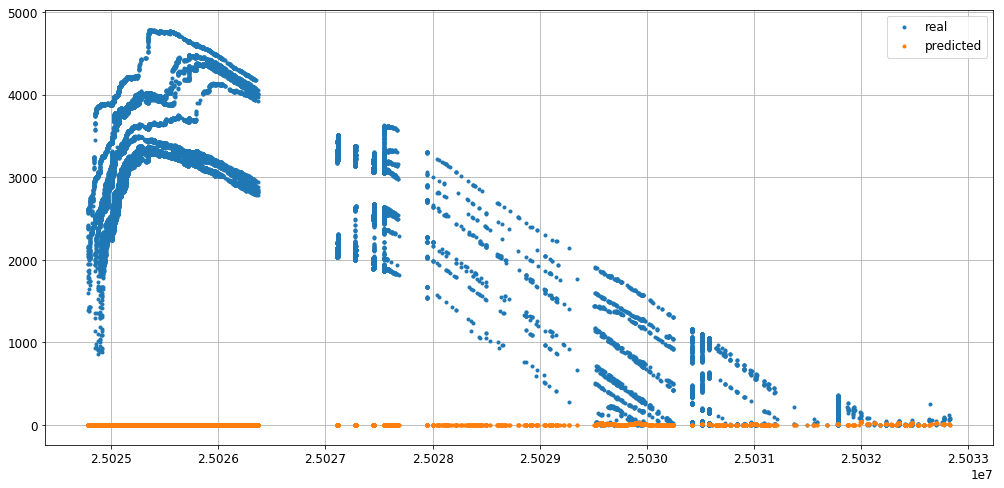

In [261]:
plt.plot(cut.SUBMITTED.values/60,cut.Q_TIME.values/60,'.', label='real')
#plt.plot(x,y,'.')
#plt.plot(x,y_out,'.', alpha=0.5)
plt.plot(cut.SUBMITTED.values/60,cut.Q_PRED.values/60,'.', label='predicted')
#lt.yscale('log')
#plt.xscale('log')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.plot(cut.SUBMITTED.values/60,cut.Q_TIME.values,'.')
plt.plot(x,y,'.')
plt.plot(x,y_out,'.', alpha=0.5)
preds = []
for t in range(0,len(y),60):
    ss = [np.mean(y[t:t+60])]*60
    preds.extend(ss)
    try:
        plt.plot(x[t:t+60], ss,'.', color='k', alpha=0.2)
    except:
        continue
#plt.yscale('log')
#plt.xscale('log')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

In [ ]:
pred = []
pred2 = []
for tup in cut.itertuples():
    pred.append(preds[int(tup.SUBMITTED/60 - cut.SUBMITTED.min()/60) - 60])
    pred2.append(preds[int(tup.SUBMITTED/60 - cut.SUBMITTED.min()/60)])
cut['Q_PRED'] = pred
cut['Q_PRED2'] = pred2
r = r2(cut.Q_TIME,cut.Q_PRED)
print (r, r2(cut.Q_TIME,cut.Q_PRED2))

In [ ]:
plt.plot(cut.SUBMITTED.values/60,cut.Q_TIME.values,'.', label='real')
#plt.plot(x,y_out,'.', alpha=0.5)
plt.plot(cut.SUBMITTED.values/60,cut.Q_PRED.values,'.', label='predicted')
plt.plot(cut.SUBMITTED.values/60,cut.Q_PRED2.values,'.', label='predicted2')
#plt.yscale('log')
#plt.xscale('log')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

In [ ]:
#cut = data.where(data.LINK == 'CERN-PROD__BNL-ATLAS__Data Consolidation').dropna()
cut2 = cut.set_index(pd.to_datetime(cut.ENDED, unit='s'))
cut2 = cut2.sort_index()


delay = 100 #10 minutes

def get_last_transfer(current_t):
    exceptions = 0
    ifs = 0
    try:
        last_timestamp1 = cut2[cut2.STARTED < current_t - delay].STARTED[-1] 
        exceptions += 1       
    except IndexError:
        last_timestamp1 = 0
    if last_timestamp1 != 0:
        last_transfer1 = cut2[cut2.STARTED == last_timestamp1]
        ifs += 1
    else:
        last_transfer1 = cut[cut.SUBMITTED == cut.SUBMITTED.min()]
    return last_transfer1, exceptions, ifs


In [ ]:
pred = []
beta = 0.001
excs = 0
ifss = 0
for tup in cut.itertuples():
    t1,exc,ifs = get_last_transfer(tup.SUBMITTED)
    y = [int(t1.STARTED.values[0] - t1.SUBMITTED.values[0])]
    s1,b1 = holt_winters_second_order_ewma(np.array(y), 1, beta)
    (ss,bb) = hwsoewma_forcast(s1,b1,beta,int((t1.STARTED.values[0] - tup.STARTED)/60))
    pred.append(ss[-1])
    excs += exc
    ifss += ifs
    #print (int((t.STARTED.values[0] - tup.STARTED)/60))
    #print (y)
cut['Q_PRED'] = pred
r = r2(cut.Q_TIME,cut.Q_PRED)
print (r, excs, ifss, len(cut))

In [ ]:
#plt.plot(cut.SUBMITTED.values/60,cut.Q_TIME.values-cut.Q_PRED.values,'.', label='real')
plt.plot(cut.SUBMITTED.values/60,cut.Q_TIME.values,'.', label='real')
#plt.plot(x,y_out,'.', alpha=0.5)
plt.plot(cut.SUBMITTED.values/60,cut.Q_PRED.values,'.', label='predicted')
#plt.plot(cut.SUBMITTED.values/60,cut.Q_PRED2.values,'.', label='predicted2')
#plt.yscale('log')
#plt.xscale('log')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

## Trying all the window sizes

In [ ]:
cut = data.where(data.LINK == 'CERN-PROD__BNL-ATLAS__Production Input').dropna()
cut = cut.sort_values(by='SUBMITTED')
cut = cut.set_index(pd.to_datetime(cut.SUBMITTED, unit='s'))
rng = pd.date_range(pd.to_datetime(cut.SUBMITTED.min(),unit='s'), periods=(cut.SUBMITTED.max() - cut.SUBMITTED.min())+1,freq='s')
s = pd.DataFrame([0]*len(rng), index=rng, columns=['Q_TIME'])
s = pd.concat([s,cut])
nr = np.append(np.zeros(1), s.Q_TIME.values)
r2_scores = []
for winsize in range(1, 1001, 1):
    #s['Q_PRED_%d'%winsize] = holt_winters_second_order_ewma(nr, winsize, 0.01)[:-1]
    pred = holt_winters_second_order_ewma(nr, winsize, 0.001)[:-1]
    r2_scores.append(r2(s.Q_TIME, pred))

In [ ]:
plt.plot(range(1,1001),r2_scores, '.', label='Max:%0.6f with ws %d'%(max(r2_scores),np.argmax(r2_scores)))
plt.title('R² scores for the next transfer for different Window Sizes')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Prediction based on the X seconds before')
plt.ylabel('R²')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

In [ ]:
max(r2_scores)